<a href="https://colab.research.google.com/github/CBravoR/AdvancedAnalyticsLabs/blob/master/Lab_6_Scorecards_and_Ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scorecards and Ensembles

In this lab we will focus on developing a scorecard using our WoE-trained dataset, and will compare it with a Random Forest created over the original data. For this, we will first import the data and re-train our original logistic regression.



## Imports and preparation

In [0]:
# Import the csv files from last week.
!wget --no-check-certificate --output-document=Bankloan_train_WoE.csv 'https://docs.google.com/spreadsheets/d/1bF5W0KAx6JytFWdKiPegMaqKgW05QEID3aAJ__ACdX4/export?gid=321666387&format=csv'
!wget --no-check-certificate --output-document=Bankloan_test_WoE.csv 'https://docs.google.com/spreadsheets/d/1hXxctlWRq3eX2BlWmhkaCSqeRKG8_u3uL3l5MEh_dJQ/export?gid=1493454936&format=csv'
!wget --no-check-certificate --output-document=Bankloan.csv 'https://docs.google.com/spreadsheets/d/1Am74y2ZVQ6dRFYVZUv_VoyP-OTS8BM4x0svifHQvtNc/export?gid=819627738&format=csv'

--2019-03-08 10:09:25--  https://docs.google.com/spreadsheets/d/1bF5W0KAx6JytFWdKiPegMaqKgW05QEID3aAJ__ACdX4/export?gid=321666387&format=csv
Resolving docs.google.com (docs.google.com)... 74.125.197.101, 74.125.197.138, 74.125.197.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.197.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘Bankloan_train_WoE.csv’

Bankloan_train_WoE.     [ <=>                ]  42.28K  --.-KB/s    in 0s      

2019-03-08 10:09:26 (83.6 MB/s) - ‘Bankloan_train_WoE.csv’ saved [43292]

--2019-03-08 10:09:27--  https://docs.google.com/spreadsheets/d/1hXxctlWRq3eX2BlWmhkaCSqeRKG8_u3uL3l5MEh_dJQ/export?gid=1493454936&format=csv
Resolving docs.google.com (docs.google.com)... 74.125.195.101, 74.125.195.100, 74.125.195.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving 

In [0]:
pip install scorecardpy

    100% |████████████████████████████████| 61kB 4.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/9d/bb/1b/057d286ee8ebb34714b4004b13f4dc71b619b41f7868cf6f98
Successfully built scorecardpy


In [1]:
import pandas as pd
import scorecardpy as sc
import numpy as np

In [2]:
# Import the files as Pandas datasets
bankloan_train_WoE = pd.read_csv('Bankloan_train_WoE.csv')
bankloan_test_WoE = pd.read_csv('Bankloan_test_WoE.csv')
bankloan_data = pd.read_csv('Bankloan.csv')

# Same filters as before
bankloan_data = bankloan_data.loc[(bankloan_data['Income'] < 300) &
                                  (bankloan_data['Creddebt'] < 15) & 
                                  (bankloan_data['OthDebt'] < 30)]

# Eliminate unused variables
bankloan_data = bankloan_data.drop(columns=['Education', 'Income', 'OthDebt'])

# Same train-test split as before (because of seed!)
bankloan_train_noWoE, bankloan_test_noWoE = sc.split_df(bankloan_data.iloc[:, 1:],
                                                        y = 'Default',
                                                        ratio = 0.7,
                                                        seed = 20190227).values()

# Give breaks for WoE
breaks_adj = {
    'MonthlyLoad': [0.1, 0.30000000000000004, 0.7000000000000001],
    'Address': [1.0, 2.0, 8.0, 17],
    'Leverage': [6.0, 14.0, 17.0],
    'Creddebt': [1.0, 3.0, 5.0],
    'Employ': [1.0, 4.0, 17.0],
    'Age': [23.0, 31.0, 47.0]
}


# Apply breaks.
bins_adj = sc.woebin(bankloan_train_noWoE, y="Default",
                     breaks_list=breaks_adj)


[INFO] creating woe binning ...


In [3]:
from sklearn.linear_model import LogisticRegression

bankloan_logreg = LogisticRegression(penalty='l1', # Type of penalization l1 = lasso, l2 = ridge
                                     tol=0.0001, # Tolerance for parameters
                                     C=1.0, # Penalty constant, see below
                                     fit_intercept=True, # Use constant?
                                     class_weight='balanced', # Weights, see below
                                     random_state=20190301, # Random seed
                                     max_iter=100, # Maximum iterations
                                     verbose=1, # Show process. 1 is yes.
                                     solver = 'saga',
                                     warm_start=False # Train anew or start from previous weights. For repeated training. 
                                    )

bankloan_logreg.fit(X = bankloan_train_WoE.iloc[:, 1:], # All rows and from the second var to end
                    y = bankloan_train_WoE['Default'] # The target
                   )

convergence after 14 epochs took 0 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=20190301, solver='saga', tol=0.0001, verbose=1,
                   warm_start=False)

## Scorecard

The first step is to create a scorecard. The package ```scorecardpy``` has the function ```scorecard``` which receives a trained WoE model, a trained scorecard **over the same variables** and a list of matched columns (that is, the order of columns in the scorecard). As optional arguments it receives a PDO, a base score, and decimal base odds (so instead of 50:1, it receives 0.02).

In [20]:
bankloan_sc = sc.scorecard(bins_adj, bankloan_logreg, 
             bankloan_train_WoE.columns[1:], # The column names in the trained LR
             points0=600, # Base points
             odds0=0.01, # Base odds
             pdo=50) # PDO 


In [21]:
bankloan_sc

{'basepoints':      variable  bin  points
 0  basepoints  NaN   268.0,
 'MonthlyLoad':        variable                                       bin  points
 21  MonthlyLoad                                [-inf,0.1)    31.0
 22  MonthlyLoad                 [0.1,0.30000000000000004)    13.0
 23  MonthlyLoad  [0.30000000000000004,0.7000000000000001)    -9.0
 24  MonthlyLoad                  [0.7000000000000001,inf)   -32.0,
 'Leverage':     variable          bin  points
 17  Leverage   [-inf,6.0)    45.0
 18  Leverage   [6.0,14.0)     5.0
 19  Leverage  [14.0,17.0)   -33.0
 20  Leverage   [17.0,inf)   -74.0,
 'Creddebt':     variable         bin  points
 13  Creddebt  [-inf,1.0)    38.0
 14  Creddebt   [1.0,3.0)   -25.0
 15  Creddebt   [3.0,5.0)    -2.0
 16  Creddebt   [5.0,inf)  -126.0,
 'Employ':   variable         bin  points
 0   Employ  [-inf,1.0)   -68.0
 1   Employ   [1.0,4.0)   -25.0
 2   Employ  [4.0,17.0)    33.0
 3   Employ  [17.0,inf)   250.0,
 'Age':    variable          bin  po

Now we have the credit score. It is in a slightly different format than the one we saw in the lectures, with a baseline points for everyone (the sum of the neutral scores) and with points per variable. Still, the analyses are the same and the points per-category can give an indication of which categories are better or worse. 

We will now get the credit scores per case.

In [22]:
# Applying the credit score. Applies over the original data!
train_score = sc.scorecard_ply(bankloan_train_noWoE, bankloan_sc, 
                               print_step=0)
test_score = sc.scorecard_ply(bankloan_test_noWoE, bankloan_sc, 
                               print_step=0)

C:\Apps\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Apps\Anaconda3\lib\site-packages\pandas\core\indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [23]:
train_score.describe()

,score
count,1026.000000
mean,297.252437
std,140.504733
min,-69.000000
25%,201.000000
50%,281.000000
75%,364.000000
max,718.000000


And that's it! We have a fully functional credit scorecard. We will contrast this with two more models: a Random Forest and an XGBoost model.

## Random Forests

Now we will train a random forest. It is included in the ```sklearn.ensemble``` subpackage, function [```RandomForestClassifier```](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), so it is straightforward to use. It comes with many parameters, but in general there is a philosophy to follow:

- In a Random Forest we want each tree to be large, and to learn as much as possible from its subset of data. We don't care too much if each tree is overadjusted, as we can always increase the number of trees to take care of this.

- This said, a good idea is to limit the minimum number of samples per leaf when we have few cases (this is not usually a problem in large trees.)

- We might want to limit the minimum impurity decrease to stop growing a tree if not much is happening.

- There is also a class weight to include. It does include one automatically if we use the option ```balanced```.

Let's train one and check the options.

In [24]:
from sklearn.ensemble import RandomForestClassifier
bankloan_rf = RandomForestClassifier(n_estimators=1000, # Number of trees to train
                       criterion='gini', # How to train the trees. Also supports entropy.
                       max_depth=None, # Max depth of the trees. Not necessary to change.
                       min_samples_split=2, # Minimum samples to create a split.
                       min_samples_leaf=0.001, # Minimum samples in a leaf. Accepts fractions for %. This is 0.1% of sample.
                       min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.
                       max_features='auto', # Maximum number of features per split (not tree!) by default is sqrt(vars)
                       max_leaf_nodes=None, # Maximum number of nodes.
                       min_impurity_decrease=0.0001, # Minimum impurity decrease. This is 10^-3.
                       bootstrap=True, # If sample with repetition. For large samples (>100.000) set to false.
                       oob_score=True,  # If report accuracy with non-selected cases.
                       n_jobs=-1, # Parallel processing. Set to -1 for all cores. Watch your RAM!!
                       random_state=20190305, # Seed
                       verbose=1, # If to give info during training. Set to 0 for silent training.
                       warm_start=False, # If train over previously trained tree.
                       class_weight='balanced'
                                    )

Now we are ready to train. We just give it our original training set variables and target.

In [25]:
bankloan_train_noWoE.describe()

,Age,Employ,Address,Leverage,Creddebt,MonthlyLoad,Default
count,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000
mean,33.880117,6.573099,6.116959,9.911988,1.693226,0.370409,0.363548
std,12.767117,8.433442,5.851659,6.484323,2.029981,0.287490,0.481255
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,0.000000,2.000000,4.900000,0.400000,0.160000,0.000000
50%,31.000000,3.000000,5.000000,8.650000,0.940000,0.295000,0.000000
75%,41.000000,9.000000,9.000000,13.700000,2.020000,0.500000,1.000000
max,77.000000,51.000000,34.000000,36.800000,13.410000,2.110000,1.000000


In [26]:
bankloan_rf.fit(bankloan_train_noWoE.iloc[:,:-1], 
               bankloan_train_noWoE['Default'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.4s finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0001,
                       min_impurity_split=None, min_samples_leaf=0.001,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=-1, oob_score=True,
                       random_state=20190305, verbose=1, warm_start=False)

We can see it used two jobs (two processors are available to us in this Google Colab server). It converges very quickly. Let's check how it did, this time we will print a nicer confusion matrix using seaborn, and will plot the ROC curve of the model. 

In [27]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

# Apply the model to the test set.
rf_pred_class_test = bankloan_rf.predict(bankloan_test_noWoE.iloc[:, :-1])
rf_probs_test = bankloan_rf.predict_proba(bankloan_test_noWoE.iloc[:, :-1])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.0s finished


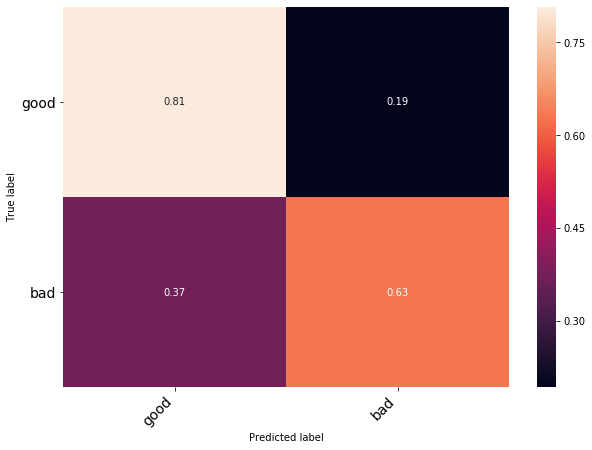

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Calculate confusion matrix
confusion_matrix_rf = confusion_matrix(y_true = bankloan_test_noWoE['Default'], 
                    y_pred = rf_pred_class_test)

# Turn matrix to percentages
confusion_matrix_rf = confusion_matrix_rf.astype('float') / confusion_matrix_rf.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_rf, index=['good', 'bad'], columns=['good', 'bad'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

Looks a bit unbalanced, but otherwise ok. It's harder to predict the defaulters. Now let's see the ROC curve.

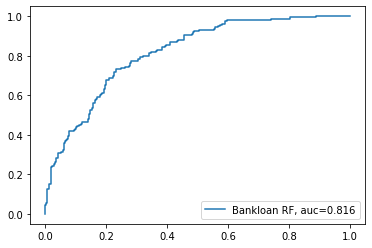

In [29]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(bankloan_test_noWoE['Default'], rf_probs_test[:,1])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = bankloan_test_noWoE['Default'], 
                             y_score = rf_probs_test[:,1]),
              decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="Bankloan RF, auc="+str(auc))
plt.legend(loc=4)
plt.show()

That's it! Now we'll compare this with an XGBoost and see which one of our three models is better.

In [30]:
for name, importance in zip(bankloan_train_noWoE.columns[:-1], bankloan_rf.feature_importances_):
  print(name, "= %.2f" % importance)

Age = 0.14
Employ = 0.18
Address = 0.08
Leverage = 0.21
Creddebt = 0.18
MonthlyLoad = 0.22


## XGBoosting

The stochastic gradient boosting model is the alternative to Random Forest. Now we want to create a series of small trees, which will be poorer in performance, but together they will be stronger. Training an XGBoost model is harder, because we need to control the model so it creates small trees, but it performs better in small data, something Random Forests do not necessarily accomplish.

Again, this is part of the ```sklearn.ensemble``` 

In [31]:
from sklearn.ensemble import GradientBoostingClassifier
bankloan_xg = GradientBoostingClassifier(loss='deviance', # How to calculate losses. Deviance is for probabilistic outputs. Alternative exponential for AdaBoost. 
                           learning_rate=0.1, # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                           n_estimators=100, # How many trees to use, the more the better, but decrease learning rate if many used.
                           subsample=0.632, # Subsampling to use. 63.2% of data is standard for XGBoost.
                           criterion='friedman_mse', # Error to use for each split. Good idea to leave it as is.
                           min_samples_split=2, # Minimum samples for a split.
                           min_samples_leaf=1, # Minimum samples in a leaf.
                           min_weight_fraction_leaf=0.0, # Minimum fraction of samples in a leaf. Consider increasing if first few trees too good.
                           max_depth=3, # Maximum depth. Keep it small!
                           min_impurity_decrease=0.01, # Minimum impurity decrease. Might want to use 1% or so.
                           init=None, # How to make first prediction (it needs one). Can give model that supports fit and predict.
                           random_state=20190305, # Seed
                           max_features='auto', # Same as RF. 
                           verbose=1,  # Same as RF.
                           max_leaf_nodes=None,  # Same as RF.
                           warm_start=False,  # Same as RF.
                           presort='auto', # Whether to presort the data to speed up training.
                           validation_fraction=0.3, # XGBoost CAN overfit, so control this just in case. Uses 30% validation in this case.
                           n_iter_no_change=None, # Iters to stop training if no change occurs between one tree and the next.
                           tol=0.0001 # Tolerance. Means maximum change of 10^-4
                          )

In [32]:
bankloan_xg.fit(bankloan_train_noWoE.iloc[:,:-1], 
                bankloan_train_noWoE['Default'])

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.2588           0.0447            0.10s
         2           1.2266           0.0321            0.10s
         3           1.1718           0.0331            0.10s
         4           1.1468           0.0271            0.10s
         5           1.1062           0.0130            0.09s
         6           1.1150           0.0202            0.11s
         7           1.0807           0.0158            0.11s
         8           1.0648           0.0123            0.10s
         9           1.0334           0.0115            0.10s
        10           1.0339           0.0091            0.11s
        20           0.9152           0.0001            0.08s
        30           0.8771           0.0005            0.07s
        40           0.8341          -0.0019            0.06s
        50           0.8222          -0.0041            0.05s
        60           0.7780          -0.0018            0.04s
       

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.01, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=20190305, subsample=0.632, tol=0.0001,
                           validation_fraction=0.3, verbose=1,
                           warm_start=False)

The verbose option gives us the error reduction. We can see it did not converge with our requested tolerance, we might want to increase the number of trees, although with 1000 cases it makes sense this will not happen.

Let's calculate the efficiency metrics.

In [33]:
# Apply the model to the test set.
xg_pred_class_test = bankloan_xg.predict(bankloan_test_noWoE.iloc[:, :-1])
xg_probs_test = bankloan_xg.predict_proba(bankloan_test_noWoE.iloc[:, :-1])

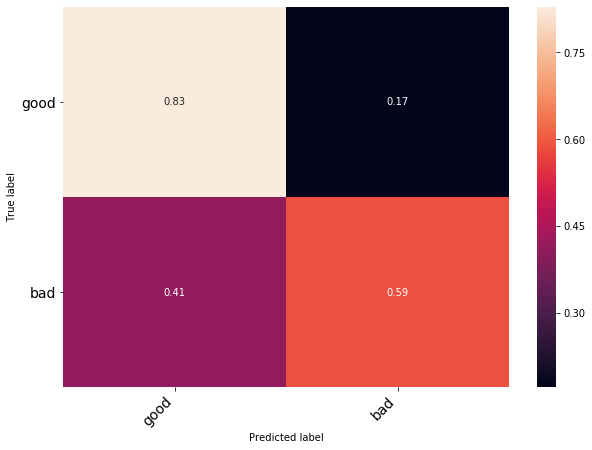

In [34]:
# Calculate confusion matrix
confusion_matrix_xg = confusion_matrix(y_true = bankloan_test_noWoE['Default'], 
                    y_pred = xg_pred_class_test)

# Turn matrix to percentages
confusion_matrix_xg = confusion_matrix_xg.astype('float') / confusion_matrix_xg.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_xg, index=['good', 'bad'], columns=['good', 'bad'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

Very similar results. Now there is no chance to use sample weights sadly, so the solution is a bit more unbalanced. This is not too much of an issue though, as we can always change the cutoff point to account for the unbalance.

Let's check the ROC curve.

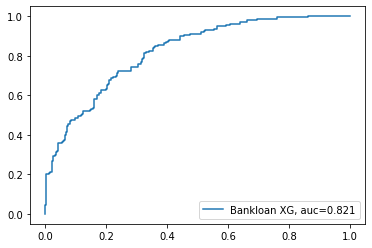

In [35]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(bankloan_test_noWoE['Default'], xg_probs_test[:,1])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = bankloan_test_noWoE['Default'], 
                             y_score = xg_probs_test[:,1]),
              decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="Bankloan XG, auc="+str(auc))
plt.legend(loc=4)
plt.show()

We can see however the XGBoost is slightly better than the Random Forest. This is probably not statistically significant though.

## Self-Study: Plotting multiple ROC curves

The last thing we would like to do is to plot multiple ROC curves in one graph. This is fairly straightforward, we just pass  the ```plt.plot``` command each of the ROC curves. I'll do dynamically using a dictionary and a for loop. 

In [36]:
# Predict probabilities of scorecard.
logreg_probs_test = bankloan_logreg.predict_proba(bankloan_test_WoE.iloc[:, 1:])

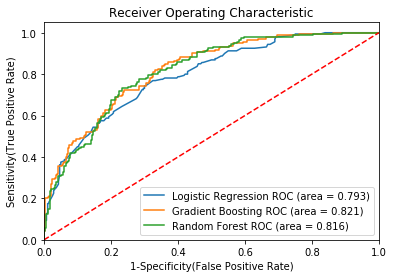

In [37]:
# Set models and probabilities. This structure is called a dictionary.
models = [
{
    'label': 'Logistic Regression',
    'probs': logreg_probs_test[:,1]
},
{
    'label': 'Gradient Boosting',
    'probs': xg_probs_test[:,1]
},
{
    'label': 'Random Forest',
    'probs': rf_probs_test[:,1]
}
]

# Loop that creates the plot. I will pass each ROC curve one by one.
for m in models:
  auc = roc_auc_score(y_true = bankloan_test_noWoE['Default'], 
                             y_score = m['probs'])
  fpr, tpr, thresholds = roc_curve(bankloan_test_WoE['Default'], 
                                           m['probs'])
  plt.plot(fpr, tpr, label='%s ROC (area = %0.3f)' % (m['label'], auc))
                 

    
# Settings
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
    
# Plot!    
plt.show()

I introduced several new concepts here. First, a dictionary. A dictionary is a very useful structure, which allows to have values indexed by a name. Every item will have their own values for its name, here the 'label' and 'probs'. I use this as an input for the for loop.

Second, check the part

```
label='%s ROC (area = %0.3f)' % (m['label'], auc)
```

of the plot definition. Note the ```%s``` and ```%0.3f``` in the string. This is a magic command that tells Python "this is a variable, in a certain format. Go look for it outside and match it in order". So in this case we have two:

- An ```%s``` which means 'This is a string'.
- A ```%0.3f``` which means 'This is a float (decimal), and I want it formatted using three decimals'.

Outside the string there is a ```% (m['label'], auc)```. This is matched one by one, the ```%s``` to the ```m['label']``` (the string), and the ```%0.3f``` to the ```auc```. This way I can create dynamically labels. Remember to use these tricks to simplify your life! 